In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/snapit-always-get-the-best-price/sample_submission.csv
/kaggle/input/snapit-always-get-the-best-price/train.csv
/kaggle/input/snapit-always-get-the-best-price/test.csv


# Importing the required libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from sklearn import preprocessing
import nltk
nltk.download('all')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    | Downloading pa

# Loading the train and test datasets

In [3]:
x_train = pd.read_csv("../input/snapit-always-get-the-best-price/train.csv")
x_test = pd.read_csv("../input/snapit-always-get-the-best-price/test.csv")

In [4]:
x_train.head()

,PRODUCT_ID,PRODUCT_NAME,PRODUCT_CONDITION,CATEGORY,PRODUCT_BRAND,SHIPPING_AVAILABILITY,PRODUCT_DESCRIPTION,PRODUCT_PRICE
0,952289,Lipstick queen reserved maiwu,4,Beauty/Makeup/Lips,NaN,0,Lipstick Queen Jean Queen and medieval lipstic...,20.0
1,121903,Garbage Pail Kids blu ray,3,Electronics/Media/Blu-Ray,NaN,1,26Plays great. Tested. Watched once. No scratc...,15.0
2,280534,green floam/slime,1,Kids/Toys/Arts & Crafts,NaN,0,"-6 oz, dragon fruit scented - KEEP OUT OF REAC...",8.0
3,787961,Wallet beige monogram,1,Women/Women's Accessories/Wallets,NaN,0,Wallet brand new never used,31.0
4,479292,Triangle Bike Or Body Blue Light,3,Sports & Outdoors/Outdoors/Other,NaN,0,"Triangle Bike Or Body Blue Light, steady or fl...",8.0


In [5]:
x_test.head()

,PRODUCT_ID,PRODUCT_NAME,PRODUCT_CONDITION,CATEGORY,PRODUCT_BRAND,SHIPPING_AVAILABILITY,PRODUCT_DESCRIPTION
0,777341,F/ship 4 Totoro Washi + 1 pen,1,Handmade/Paper Goods/Stationery,NaN,1,This listing is for all 4 Totoro washi tape fo...
1,1463629,UCLA Men's Bundle + Shorts,1,Women/Other/Other,Adidas,1,7 items. 1: XL. 2: 2XL. 3:2XL. 4: XL. 5: 2XL. ...
2,350669,Listing for lol,1,Beauty/Makeup/Lips,NaN,1,- sunglasses and necklace :)
3,310222,25 pcs kawaii sticker flakes,1,Kids/Toys/Arts & Crafts,NaN,1,I ordered a bunch of stickers so you will reci...
4,759257,Chanel Mini Lipgloss Set,2,Beauty/Makeup/Lips,Chanel,1,Brand new never used authentic Mini Lipgloss g...


# Detecting null values 

In [6]:
x_train.isna().sum()

PRODUCT_ID                    0
PRODUCT_NAME                  0
PRODUCT_CONDITION             0
CATEGORY                   5416
PRODUCT_BRAND            537885
SHIPPING_AVAILABILITY         0
PRODUCT_DESCRIPTION           3
PRODUCT_PRICE                 0
dtype: int64

In [7]:
x_test.isna().sum()

PRODUCT_ID                   0
PRODUCT_NAME                 0
PRODUCT_CONDITION            0
CATEGORY                   911
PRODUCT_BRAND            94797
SHIPPING_AVAILABILITY        0
PRODUCT_DESCRIPTION          1
dtype: int64

# Handling null values

In [8]:
x_train.drop(axis="columns",labels="PRODUCT_ID",inplace=True)
x_train.drop(axis="rows",labels=x_train.index[x_train["CATEGORY"].isna()],inplace=True)
x_train.drop(axis="rows",labels=x_train.index[x_train["PRODUCT_DESCRIPTION"].isna()],inplace=True)
x_train.drop(axis="rows",labels=x_train.index[x_train["PRODUCT_PRICE"].isna()],inplace=True)

# Filling the null values of PRODUCT_BRAND,CATEGORY and PRODUCT_DESCRIPTION with 'Others'

In [9]:
x_train["PRODUCT_BRAND"].fillna("OTHERS", inplace=True)


In [10]:
x_test["PRODUCT_BRAND"].fillna("OTHERS", inplace=True)
x_test["CATEGORY"].fillna("other/other/other", inplace=True)
x_test["PRODUCT_DESCRIPTION"].fillna("other", inplace=True)

In [11]:
x_train.isna().sum()

PRODUCT_NAME             0
PRODUCT_CONDITION        0
CATEGORY                 0
PRODUCT_BRAND            0
SHIPPING_AVAILABILITY    0
PRODUCT_DESCRIPTION      0
PRODUCT_PRICE            0
dtype: int64

In [12]:
x_test.isna().sum()

PRODUCT_ID               0
PRODUCT_NAME             0
PRODUCT_CONDITION        0
CATEGORY                 0
PRODUCT_BRAND            0
SHIPPING_AVAILABILITY    0
PRODUCT_DESCRIPTION      0
dtype: int64

# Splitting the column MAIN_CATEGORY with the delimiter /

In [13]:
x_train[['MAIN_CATEGORY','SUB_CATEGORY1','SUB_CATEGORY2','SUB_CATEGORY3','SUB_CATEGORY4']]=x_train['CATEGORY'].str.split('/', expand=True)
x_test[['MAIN_CATEGORY','SUB_CATEGORY1','SUB_CATEGORY2','SUB_CATEGORY3','SUB_CATEGORY4']]=x_test['CATEGORY'].str.split('/', expand=True)

# Outlier Detection

<AxesSubplot:xlabel='PRODUCT_PRICE', ylabel='MAIN_CATEGORY'>

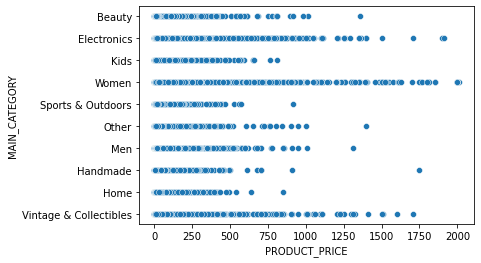

In [14]:
sns.scatterplot(data=x_train, y="MAIN_CATEGORY", x="PRODUCT_PRICE")

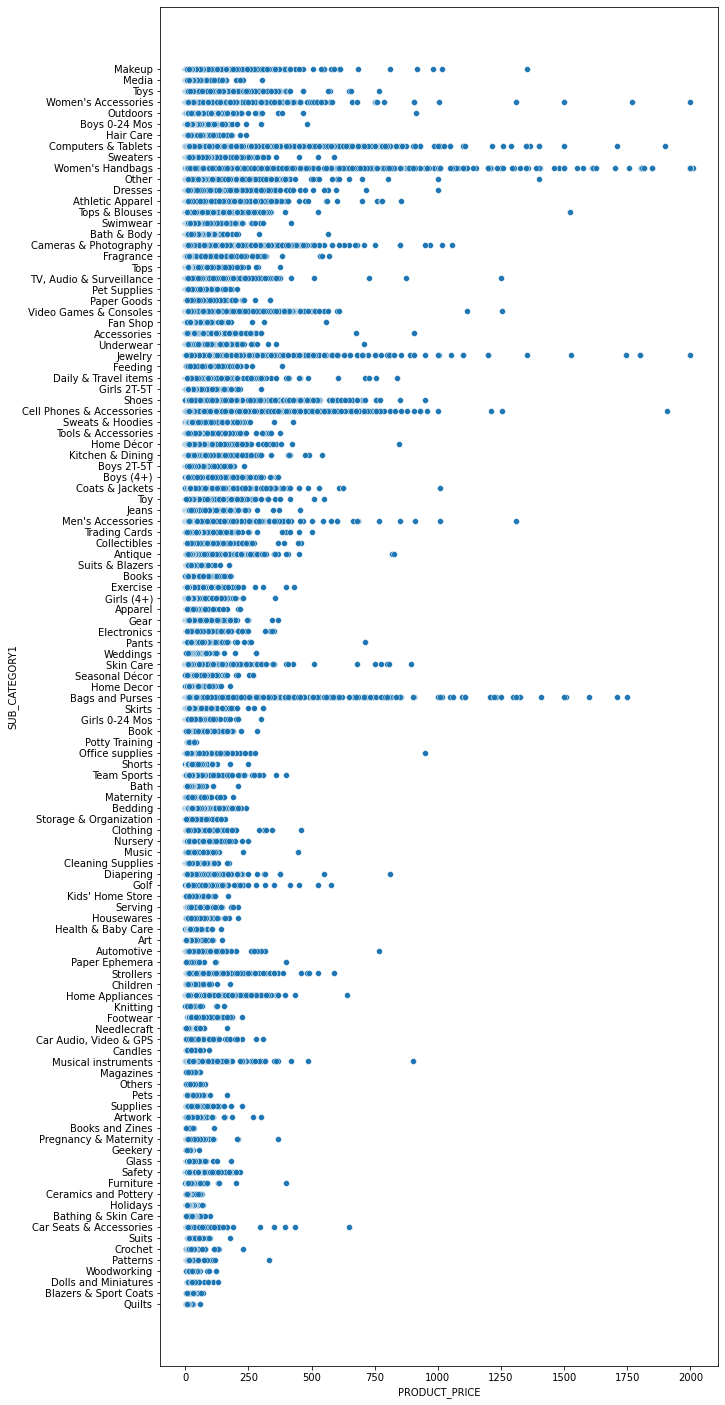

In [15]:
plt.figure(figsize=(10,25))
sns.scatterplot(data=x_train, y="SUB_CATEGORY1", x="PRODUCT_PRICE")
plt.title('')
plt.show()

# Outlier Removal

In [16]:
'''outlier1=x_train[(x_train['MAIN_CATEGORY']=='Beauty')&(x_train['PRODUCT_PRICE']>1250)]
outlier2=x_train[(x_train['MAIN_CATEGORY']=='Sports & Outdoors')&(x_train['PRODUCT_PRICE']>750)]
outlier3=x_train[(x_train['MAIN_CATEGORY']=='Handmade')&(x_train['PRODUCT_PRICE']>1500)]
outlier4=x_train[(x_train['SUB_CATEGORY1']=='Makeup')&(x_train['PRODUCT_PRICE']>1100)]
outlier5=x_train[(x_train['SUB_CATEGORY1']=='Women\'s Accessories')&(x_train['PRODUCT_PRICE']>1100)]
outlier6=x_train[(x_train['SUB_CATEGORY1']=='Outdoors')&(x_train['PRODUCT_PRICE']>500)]
outlier7=x_train[(x_train['SUB_CATEGORY1']=='Other')&(x_train['PRODUCT_PRICE']>1100)]
outlier8=x_train[(x_train['SUB_CATEGORY1']=='Tops & Blouses')&(x_train['PRODUCT_PRICE']>1100)]
outlier9=x_train[(x_train['SUB_CATEGORY1']=='TV, Audio & Surveillance')&(x_train['PRODUCT_PRICE']>500)]
outlier10=x_train[(x_train['SUB_CATEGORY1']=='Video Games & Consoles')&(x_train['PRODUCT_PRICE']>1100)]
outlier11=x_train[(x_train['SUB_CATEGORY1']=='Cell Phones & Accessories')&(x_train['PRODUCT_PRICE']>1100)]
outlier12=x_train[(x_train['SUB_CATEGORY1']=='Men\'s Accessories')&(x_train['PRODUCT_PRICE']>1100)]
outlier13=x_train[(x_train['SUB_CATEGORY1']=='Office supplies')&(x_train['PRODUCT_PRICE']>750)]'''

"outlier1=x_train[(x_train['MAIN_CATEGORY']=='Beauty')&(x_train['PRODUCT_PRICE']>1250)]\noutlier2=x_train[(x_train['MAIN_CATEGORY']=='Sports & Outdoors')&(x_train['PRODUCT_PRICE']>750)]\noutlier3=x_train[(x_train['MAIN_CATEGORY']=='Handmade')&(x_train['PRODUCT_PRICE']>1500)]\noutlier4=x_train[(x_train['SUB_CATEGORY1']=='Makeup')&(x_train['PRODUCT_PRICE']>1100)]\noutlier5=x_train[(x_train['SUB_CATEGORY1']=='Women's Accessories')&(x_train['PRODUCT_PRICE']>1100)]\noutlier6=x_train[(x_train['SUB_CATEGORY1']=='Outdoors')&(x_train['PRODUCT_PRICE']>500)]\noutlier7=x_train[(x_train['SUB_CATEGORY1']=='Other')&(x_train['PRODUCT_PRICE']>1100)]\noutlier8=x_train[(x_train['SUB_CATEGORY1']=='Tops & Blouses')&(x_train['PRODUCT_PRICE']>1100)]\noutlier9=x_train[(x_train['SUB_CATEGORY1']=='TV, Audio & Surveillance')&(x_train['PRODUCT_PRICE']>500)]\noutlier10=x_train[(x_train['SUB_CATEGORY1']=='Video Games & Consoles')&(x_train['PRODUCT_PRICE']>1100)]\noutlier11=x_train[(x_train['SUB_CATEGORY1']=='Cell P

In [17]:
'''x_train.drop([635637], axis=0, inplace=True)
x_train.drop([1117879], axis=0, inplace=True)
x_train.drop([32533], axis=0, inplace=True)
x_train.drop([249642], axis=0, inplace=True)
x_train.drop([391771], axis=0, inplace=True)
x_train.drop([1061304], axis=0, inplace=True)
x_train.drop([1112384], axis=0, inplace=True)
x_train.drop([528576], axis=0, inplace=True)
x_train.drop([1247946], axis=0, inplace=True)
x_train.drop([41289], axis=0, inplace=True)
x_train.drop([123410], axis=0, inplace=True)
x_train.drop([233174], axis=0, inplace=True)
x_train.drop([708412], axis=0, inplace=True)
x_train.drop([201310], axis=0, inplace=True)
x_train.drop([846199], axis=0, inplace=True)
x_train.drop([577750], axis=0, inplace=True)
x_train.drop([781189], axis=0, inplace=True)
x_train.drop([1134785], axis=0, inplace=True)
x_train.drop([761059], axis=0, inplace=True)
x_train.drop([231213], axis=0, inplace=True)'''

'x_train.drop([635637], axis=0, inplace=True)\nx_train.drop([1117879], axis=0, inplace=True)\nx_train.drop([32533], axis=0, inplace=True)\nx_train.drop([249642], axis=0, inplace=True)\nx_train.drop([391771], axis=0, inplace=True)\nx_train.drop([1061304], axis=0, inplace=True)\nx_train.drop([1112384], axis=0, inplace=True)\nx_train.drop([528576], axis=0, inplace=True)\nx_train.drop([1247946], axis=0, inplace=True)\nx_train.drop([41289], axis=0, inplace=True)\nx_train.drop([123410], axis=0, inplace=True)\nx_train.drop([233174], axis=0, inplace=True)\nx_train.drop([708412], axis=0, inplace=True)\nx_train.drop([201310], axis=0, inplace=True)\nx_train.drop([846199], axis=0, inplace=True)\nx_train.drop([577750], axis=0, inplace=True)\nx_train.drop([781189], axis=0, inplace=True)\nx_train.drop([1134785], axis=0, inplace=True)\nx_train.drop([761059], axis=0, inplace=True)\nx_train.drop([231213], axis=0, inplace=True)'

In [18]:
trntmp=x_train.copy (deep=True)
tsttmp=x_test.copy (deep=True)

# Stopword Removal

In [19]:
from nltk.corpus import stopwords

In [20]:
!pip install contractions


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 789.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 3.1 MB/s eta 0:00:00a 0:00:01


In [21]:
import contractions

In [22]:
from nltk.corpus import stopwords
import contractions
stopwords = nltk.corpus.stopwords.words('english')

def stopword_removal(data):
    preproc = []
    for i in tqdm(data):
        abc = contractions.fix(i)
        abc = abc.replace('\\r', ' ')
        abc = abc.replace('\\"', ' ')
        abc = abc.replace('\\n', ' ')
        abc = re.sub('[^A-Za-z0-9]+', ' ', abc)
        abc = ' '.join(e for e in abc.split() if e not in stopwords)
        preproc.append(abc.lower().strip())
    return preproc

In [23]:
x_train['Processed_name'] = stopword_removal(x_train['PRODUCT_NAME'])
x_test['Processed_name'] = stopword_removal(x_test['PRODUCT_NAME'])
x_train['Processed_desc'] = stopword_removal(x_train['PRODUCT_DESCRIPTION'])
x_test['Processed_desc'] = stopword_removal(x_test['PRODUCT_DESCRIPTION'])

100%|██████████| 222381/222381 [00:23<00:00, 9575.80it/s] 


# Stemming

In [ ]:
'''from nltk.stem import PorterStemmer
porter = PorterStemmer()
x_train['processed_name'] = x_train['processed_name'].apply(porter.stem)
x_test['processed_name'] = x_test['processed_name'].apply(porter.stem)
x_train['processed_desc'] = x_train['processed_desc'].apply(porter.stem)
x_test['processed_desc'] = x_train['processed_desc'].apply(porter.stem)'''

Lemmatization

In [ ]:
'''import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
x_train['processed_name'] = x_train['processed_name'].apply(lemmatizer.lemmatize)
x_test['processed_name'] = x_test['processed_name'].apply(lemmatizer.lemmatize)
x_train['processed_desc'] = x_train['processed_desc'].apply(lemmatizer.lemmatize)
x_test['processed_desc'] = x_train['processed_desc'].apply(lemmatizer.lemmatize)'''

# Dropping the original columns after updation

In [24]:
x_train.drop(axis="columns",labels="PRODUCT_DESCRIPTION",inplace=True)
x_train.drop(axis="columns",labels="PRODUCT_NAME",inplace=True)
x_test.drop(axis="columns",labels="PRODUCT_DESCRIPTION",inplace=True)
x_test.drop(axis="columns",labels="PRODUCT_NAME",inplace=True)
x_train.drop(axis="columns",labels="CATEGORY",inplace=True)
x_test.drop(axis="columns",labels="CATEGORY",inplace=True)

# Applying log to the output column

In [25]:
y_train = np.log1p(x_train['PRODUCT_PRICE'])

In [26]:
x_train.drop(axis="columns",labels="PRODUCT_PRICE",inplace=True)

In [27]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
y_train=y_train.values
#y_train.reshape((-1,1))
y_train=y_train.reshape((-1,1))
print(y_train.shape)

(1254735, 10)
(222381, 11)
(1254735,)
(1254735, 1)


Dropped the columns of SUB_CATEGORY 3 and 4

In [28]:
x_train.drop(axis="columns",labels="SUB_CATEGORY3",inplace=True)
x_test.drop(axis="columns",labels="SUB_CATEGORY3",inplace=True)
x_train.drop(axis="columns",labels="SUB_CATEGORY4",inplace=True)
x_test.drop(axis="columns",labels="SUB_CATEGORY4",inplace=True)

Ordinal Encoding

In [29]:
'''from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

label_encode = OrdinalEncoder( handle_unknown='use_encoded_value',unknown_value=-1)

label_encode.fit(x_train.clean_brand.values.reshape(-1,1))
train_vec_brand =label_encode.transform(x_train.clean_brand.values.reshape(-1,1)) 
test_vec_brand = label_encode.transform(x_test.clean_brand.values.reshape(-1,1))

label_encode.fit(x_train.clean_maincat.values.reshape(-1,1)) 
train_vec_maincat =label_encode.transform(x_train.clean_maincat.values.reshape(-1,1)) 
test_vec_maincat = label_encode.transform(x_test.clean_maincat.values.reshape(-1,1))


label_encode.fit(x_train.clean_maincat.values.reshape(-1,1))
train_vec_subcat1 =label_encode.transform(x_train.clean_subcat1.values.reshape(-1,1))
test_vec_subcat1 = label_encode.transform(x_test.clean_subcat1.values.reshape(-1,1))


label_encode.fit(x_train.clean_maincat.values.reshape(-1,1))
train_vec_subcat2 =label_encode.transform(x_train.clean_subcat2.values.reshape(-1,1)) 
test_vec_subcat2 = label_encode.transform(x_test.clean_subcat2.values.reshape(-1,1))'''

"from numpy import asarray\nfrom sklearn.preprocessing import OrdinalEncoder\n\nlabel_encode = OrdinalEncoder( handle_unknown='use_encoded_value',unknown_value=-1)\n\nlabel_encode.fit(x_train.clean_brand.values.reshape(-1,1))\ntrain_vec_brand =label_encode.transform(x_train.clean_brand.values.reshape(-1,1)) \ntest_vec_brand = label_encode.transform(x_test.clean_brand.values.reshape(-1,1))\n\nlabel_encode.fit(x_train.clean_maincat.values.reshape(-1,1)) \ntrain_vec_maincat =label_encode.transform(x_train.clean_maincat.values.reshape(-1,1)) \ntest_vec_maincat = label_encode.transform(x_test.clean_maincat.values.reshape(-1,1))\n\n\nlabel_encode.fit(x_train.clean_maincat.values.reshape(-1,1))\ntrain_vec_subcat1 =label_encode.transform(x_train.clean_subcat1.values.reshape(-1,1))\ntest_vec_subcat1 = label_encode.transform(x_test.clean_subcat1.values.reshape(-1,1))\n\n\nlabel_encode.fit(x_train.clean_maincat.values.reshape(-1,1))\ntrain_vec_subcat2 =label_encode.transform(x_train.clean_subcat2

# Applying Count Vectorizer to Product_Brand, Category columns,  Product_Name and Product_Description columns

In [30]:
'''vector1 = CountVectorizer(lowercase=False, binary=True)
train_pb = vector1.fit_transform(x_train['PRODUCT_BRAND'].values)
test_pb = vector1.transform(x_test['PRODUCT_BRAND'].values)
train_mc = vector1.fit_transform(x_train['MAIN_CATEGORY'].values)
test_mc = vector1.transform(x_test['MAIN_CATEGORY'].values)
train_sc1 = vector1.fit_transform(x_train['SUB_CATEGORY1'].values)
test_sc1 = vector1.transform(x_test['SUB_CATEGORY1'].values)
train_sc2 = vector1.fit_transform(x_train['SUB_CATEGORY2'].values)
test_sc2 = vector1.transform(x_test['SUB_CATEGORY2'].values)
train_pren = vector1.fit_transform(x_train['PRODUCT_NAME'].values)
test_pren = vector1.transform(x_test['PRODUCT_NAME'].values)
train_predc = vector1.fit_transform(x_train['PRODUCT_DESCRIPTION'].values)
test_predc = vector1.transform(x_test['PRODUCT_DESCRIPTION'].values)'''

"vector1 = CountVectorizer(lowercase=False, binary=True)\ntrain_pb = vector1.fit_transform(x_train['PRODUCT_BRAND'].values)\ntest_pb = vector1.transform(x_test['PRODUCT_BRAND'].values)\ntrain_mc = vector1.fit_transform(x_train['MAIN_CATEGORY'].values)\ntest_mc = vector1.transform(x_test['MAIN_CATEGORY'].values)\ntrain_sc1 = vector1.fit_transform(x_train['SUB_CATEGORY1'].values)\ntest_sc1 = vector1.transform(x_test['SUB_CATEGORY1'].values)\ntrain_sc2 = vector1.fit_transform(x_train['SUB_CATEGORY2'].values)\ntest_sc2 = vector1.transform(x_test['SUB_CATEGORY2'].values)\ntrain_pren = vector1.fit_transform(x_train['PRODUCT_NAME'].values)\ntest_pren = vector1.transform(x_test['PRODUCT_NAME'].values)\ntrain_predc = vector1.fit_transform(x_train['PRODUCT_DESCRIPTION'].values)\ntest_predc = vector1.transform(x_test['PRODUCT_DESCRIPTION'].values)"

# Applying TF-IDF Vectorizer to Product_Brand, Category columns,  Product_Name and Product_Description columns

In [32]:
x_test['Processed_desc']=x_test['Processed_desc'].fillna(' ')

In [33]:
vector1 = TfidfVectorizer()
train_pb = vector1.fit_transform(x_train['PRODUCT_BRAND'].values)
test_pb = vector1.transform(x_test['PRODUCT_BRAND'].values)
train_mc = vector1.fit_transform(x_train['MAIN_CATEGORY'].values)
test_mc = vector1.transform(x_test['MAIN_CATEGORY'].values)
train_sc1 = vector1.fit_transform(x_train['SUB_CATEGORY1'].values)
test_sc1 = vector1.transform(x_test['SUB_CATEGORY1'].values)
train_sc2 = vector1.fit_transform(x_train['SUB_CATEGORY2'].values)
test_sc2 = vector1.transform(x_test['SUB_CATEGORY2'].values)
train_pren = vector1.fit_transform(x_train['Processed_name'].values)
test_pren = vector1.transform(x_test['Processed_name'].values)
train_predc = vector1.fit_transform(x_train['Processed_desc'].values)
test_predc = vector1.transform(x_test['Processed_desc'].values)

In [34]:
print(train_pb.shape,test_pb.shape)
print(train_mc.shape, test_mc.shape)
print(train_sc1.shape, test_sc1.shape)
print(train_sc2.shape,test_sc2.shape)
print(train_pren.shape,test_pren.shape)
print(train_predc.shape,test_predc.shape)

(1254735, 4880) (222381, 4880)
(1254735, 12) (222381, 12)
(1254735, 141) (222381, 141)
(1254735, 960) (222381, 960)
(1254735, 95358) (222381, 95358)
(1254735, 146244) (222381, 146244)


replacing NaNs with space

In [35]:
x_train

,PRODUCT_CONDITION,PRODUCT_BRAND,SHIPPING_AVAILABILITY,MAIN_CATEGORY,SUB_CATEGORY1,SUB_CATEGORY2,Processed_name,Processed_desc
0,4,OTHERS,0,Beauty,Makeup,Lips,lipstick queen reserved maiwu,lipstick queen jean queen medieval lipstick us...
1,3,OTHERS,1,Electronics,Media,Blu-Ray,garbage pail kids blu ray,26plays great tested watched no scratches
2,1,OTHERS,0,Kids,Toys,Arts & Crafts,green floam slime,6 oz dragon fruit scented keep out of reach of...
3,1,OTHERS,0,Women,Women's Accessories,Wallets,wallet beige monogram,wallet brand new never used
4,3,OTHERS,0,Sports & Outdoors,Outdoors,Other,triangle bike or body blue light,triangle bike or body blue light steady flashi...
...,...,...,...,...,...,...,...,...
1260149,3,Brooks Brothers,0,Kids,Girls (4+),Dresses,brooks brothers girls,beautiful dress another favorites sz 6 beautif...
1260150,1,OTHERS,0,Women,Tops & Blouses,Knit Top,lularoe randy size large,brand new never worn washed size large navy sl...
1260151,1,OTHERS,0,Kids,Toys,Dolls & Accessories,this sale,american girl doll tenney comes doll book guit...
1260152,1,Apple,0,Electronics,Cell Phones & Accessories,Cables & Adapters,iphone headphone lightning cable split,no description yet


# Converting the numerical columns to csr matrix

In [36]:
X_tr_ = csr_matrix(pd.get_dummies(x_train[['PRODUCT_CONDITION', 'SHIPPING_AVAILABILITY']], sparse=True).values)
X_te_ = csr_matrix(pd.get_dummies(x_test[['PRODUCT_CONDITION', 'SHIPPING_AVAILABILITY']], sparse=True).values)

print(X_tr_.shape,  X_te_.shape)

(1254735, 2) (222381, 2)


# Stacking all these columns

In [37]:
train_csr = hstack((train_pb, train_mc, 
                       train_sc1, train_sc2, \
               train_pren, train_predc, X_tr_)).tocsr()
test_csr = hstack((test_pb, test_mc,
                      test_sc1, test_sc2, \
               test_pren, test_predc, X_te_)).tocsr()

In [38]:
print(train_csr.shape,  test_csr.shape)

(1254735, 247597) (222381, 247597)


In [39]:
x_train

,PRODUCT_CONDITION,PRODUCT_BRAND,SHIPPING_AVAILABILITY,MAIN_CATEGORY,SUB_CATEGORY1,SUB_CATEGORY2,Processed_name,Processed_desc
0,4,OTHERS,0,Beauty,Makeup,Lips,lipstick queen reserved maiwu,lipstick queen jean queen medieval lipstick us...
1,3,OTHERS,1,Electronics,Media,Blu-Ray,garbage pail kids blu ray,26plays great tested watched no scratches
2,1,OTHERS,0,Kids,Toys,Arts & Crafts,green floam slime,6 oz dragon fruit scented keep out of reach of...
3,1,OTHERS,0,Women,Women's Accessories,Wallets,wallet beige monogram,wallet brand new never used
4,3,OTHERS,0,Sports & Outdoors,Outdoors,Other,triangle bike or body blue light,triangle bike or body blue light steady flashi...
...,...,...,...,...,...,...,...,...
1260149,3,Brooks Brothers,0,Kids,Girls (4+),Dresses,brooks brothers girls,beautiful dress another favorites sz 6 beautif...
1260150,1,OTHERS,0,Women,Tops & Blouses,Knit Top,lularoe randy size large,brand new never worn washed size large navy sl...
1260151,1,OTHERS,0,Kids,Toys,Dolls & Accessories,this sale,american girl doll tenney comes doll book guit...
1260152,1,Apple,0,Electronics,Cell Phones & Accessories,Cables & Adapters,iphone headphone lightning cable split,no description yet


In [40]:
X_train = train_csr.tocsr()
X_test = test_csr.tocsr()

# Fitting the model- Ridge Regression

In [41]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

 # Applying RMSE

In [42]:
ridge_ptr = ridge.predict(X_train)
actual_pred = ridge.predict(X_test)
ridge_pte = np.expm1(actual_pred)#Applying Inverse log
print('RMSLE for train data:', sqrt(mse(y_train, ridge_ptr)))

RMSLE for train data: 0.4321955433441491


# Fitting the model- Lasso Regression and # Applying RMSE

In [43]:
'''from sklearn import linear_model
model = linear_model.Lasso() 
model.fit(X_train, y_train)
lasso_preds_tr = model.predict(X_train)
actpred = model.predict(X_test)
lasso_preds_te = np.expm1(actpred)
'''

'from sklearn import linear_model\nmodel = linear_model.Lasso() \nmodel.fit(X_train, y_train)\nlasso_preds_tr = model.predict(X_train)\nactpred = model.predict(X_test)\nlasso_preds_te = np.expm1(actpred)\n'

# Fitting the model- XGB Regression and # Applying RMSE

In [44]:
'''!pip install xgboost
import xgboost as xgb
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train,y_train)
xg_preds_tr = xgb_reg.predict(X_train)
xg_preds_te = xgb_reg.predict(X_test)
actpred_xg = np.expm1(xg_preds_te)
'''

'!pip install xgboost\nimport xgboost as xgb\nxgb_reg = xgb.XGBRegressor()\nxgb_reg.fit(X_train,y_train)\nxg_preds_tr = xgb_reg.predict(X_train)\nxg_preds_te = xgb_reg.predict(X_test)\nactpred_xg = np.expm1(xg_preds_te)\n'

# Fitting the model- Linear SVR and # Applying RMSE

In [45]:
'''from sklearn.svm import LinearSVR
model_svr = LinearSVR()
model_svr.fit(X_train, y_train)
svr_ptr = model_svr.predict(X_train)
actual_pred = model_svr.predict(X_test)
svr_pte = np.expm1(actual_pred)#Applying Inverse log
'''

'from sklearn.svm import LinearSVR\nmodel_svr = LinearSVR()\nmodel_svr.fit(X_train, y_train)\nsvr_ptr = model_svr.predict(X_train)\nactual_pred = model_svr.predict(X_test)\nsvr_pte = np.expm1(actual_pred)#Applying Inverse log\n'

# Creating the Submission File

In [46]:
submission=x_test[["PRODUCT_ID"]]
submission

,PRODUCT_ID
0,777341
1,1463629
2,350669
3,310222
4,759257
...,...
222376,491588
222377,1410603
222378,207926
222379,241496


In [48]:
submission["PRODUCT_PRICE"]=ridge_pte

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
submission

,PRODUCT_ID,PRODUCT_PRICE
0,777341,6.192639
1,1463629,19.035329
2,350669,10.866253
3,310222,4.696477
4,759257,20.184342
...,...,...
222376,491588,33.861028
222377,1410603,27.586753
222378,207926,14.000083
222379,241496,14.257819


In [50]:
submission[['PRODUCT_ID', 'PRODUCT_PRICE']].to_csv('submission.csv',index=False)